## DTW Quickstart

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



<Axes: >

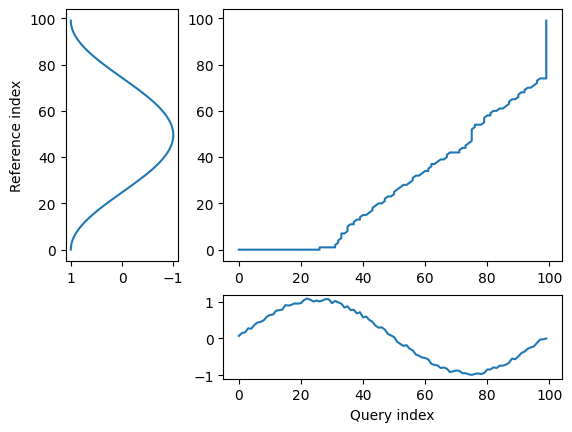

In [2]:
idx = np.linspace(0, 6.28, num=100)
query = np.sin(idx) + np.random.uniform(size=100) / 10.0

template = np.cos(idx)
alignment = dtw(query, template, keep_internals=True)

alignment.plot(type="threeway")

### DTW for time series in pose estimation

In [3]:
POSITION_COLUMNS = ["x", "y", "z"]

reference_video_angles_df = pd.read_csv(
    "../data/squat/features/reference/angles.csv"
).pivot(index="frame", columns="name", values="value")
reference_video_angles_df.head()

name,left_elbow,left_hip,left_knee,left_shoulder,right_elbow,right_hip,right_knee,right_shoulder
frame,,,,,,,,
1,91.856137,157.502077,166.832700,161.269961,99.602255,141.315950,168.967960,59.227529
2,93.638886,158.756675,168.839592,162.841424,63.947237,145.076911,171.344022,64.033283
3,92.754863,158.890374,169.034575,163.129227,64.289569,147.006973,172.361784,64.792921
4,92.525122,160.252532,169.583015,163.692430,57.568091,147.743441,172.816626,65.663286
5,91.697268,160.645424,169.759264,164.137084,50.092294,148.626369,173.543875,66.696529


In [4]:
query_video_angles_df = pd.read_csv("../results/query_squat/rep_1/angles.csv").pivot(
    index="frame", columns="name", values="value"
)
query_video_angles_df.head()

name,left_elbow,left_hip,left_knee,left_shoulder,right_elbow,right_hip,right_knee,right_shoulder
frame,,,,,,,,
434,70.971129,128.285295,159.527275,139.116481,100.951293,116.730547,147.971859,123.112828
435,73.362321,132.745012,161.982067,142.366159,104.869516,119.867921,149.657237,124.011617
436,73.079994,140.115302,170.777800,142.884338,113.350468,124.929690,153.986836,124.773263
437,82.488888,143.188342,170.295889,145.027861,122.067864,128.014101,156.664053,123.417633
438,81.018990,144.907281,165.477723,148.616261,141.003675,134.952607,163.964314,113.094382


Both datasets are now filtered and grouped. Let's assume only importance on one of the knees (right in this case).

In [5]:
from sklearn.preprocessing import MinMaxScaler


def filter(signal: np.ndarray, fps=10) -> np.ndarray:
    cutoff_freq = fps
    kernel = np.ones(cutoff_freq) / cutoff_freq
    filtered_signal = np.convolve(signal, kernel, mode="same")
    return filtered_signal


def get_exercise_signal(data: pd.DataFrame, signal_features: int = 1):
    scaler = MinMaxScaler()
    important_features = (
        data.std().sort_values(ascending=False)[:signal_features].keys()
    )
    important_angles_df = data[important_features]
    important_angles_normalized = scaler.fit_transform(important_angles_df)
    signal = important_angles_normalized.mean(axis=1)
    return filter(signal)

In [6]:
reference_signal = get_exercise_signal(reference_video_angles_df)
query_signal = get_exercise_signal(query_video_angles_df)

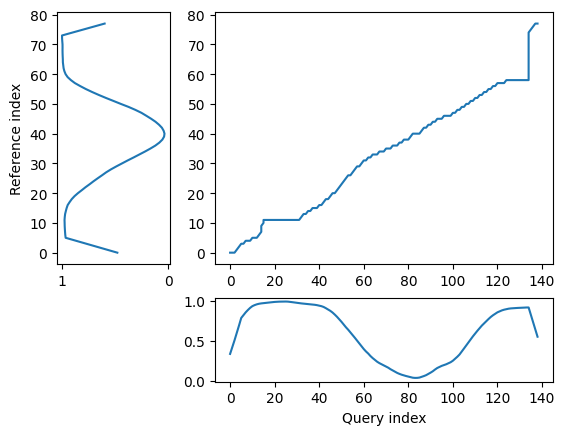

In [40]:
alignment = dtw(query_signal, reference_signal, keep_internals=True)
frames_warped = alignment.index1
reference_to_query = alignment.index1
query_to_reference = alignment.index2
alignment.plot(type="threeway");

In [41]:
def filter_repetable_reference_indexes(
    referene_to_query: np.ndarray, query_to_refernce: np.ndarray
) -> np.ndarray:
    query_to_refernce_cp = query_to_refernce.copy()

    for idx in range(len(referene_to_query) - 1, -1, -1):
        if idx > 0 and referene_to_query[idx] == referene_to_query[idx - 1]:
            query_to_refernce_cp = np.delete(query_to_refernce_cp, idx)

    return query_to_refernce_cp

In [42]:
query_to_refernce_warped_frames = filter_repetable_reference_indexes(
    reference_to_query, query_to_refernce
)

Let's visualize that in 3D (Unfortunetly `dtw-python` allows only one dimention data for threeway plotting).

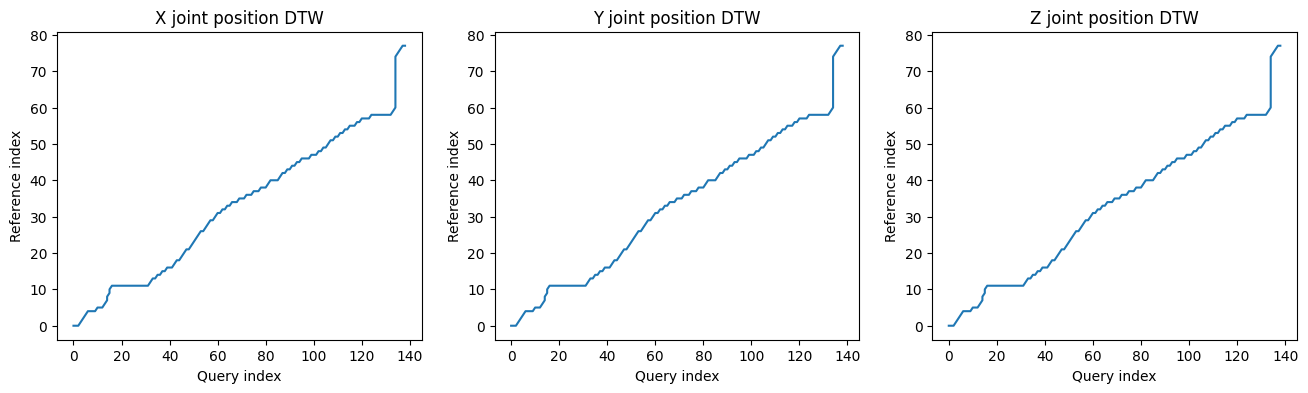

In [19]:
joints_positions = ["X", "Y", "Z"]

_, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for idx, axis in enumerate(axes):
    axis.plot(query_to_reference, reference_to_query)
    axis.set_title(f"{joints_positions[idx]} joint position DTW")
    axis.set_xlabel("Query index")
    axis.set_ylabel("Reference index")

<Axes: xlabel='Index', ylabel='Query value'>

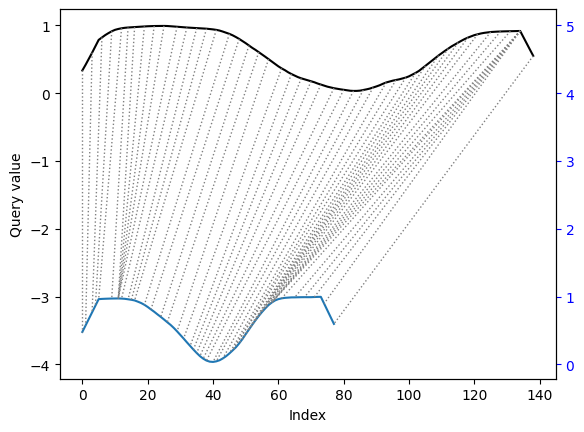

In [17]:
dtw(np.array(query_signal), np.array(reference_signal), keep_internals=True).plot(
    type="twoway", offset=-4
)